In [2]:
import pandas as pd
import numpy as np
import pickle

In [144]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns
sns.set()

In [20]:
from datetime import datetime

In [163]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
from sklearn.model_selection import (cross_val_score, cross_val_predict, train_test_split, 
                                     KFold, GridSearchCV)
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# The goal is to predict departing flights that will be delayed. A flight is considered delay when it takes more than 15 minutes to leave the gate. 

Within the delta dataframe, there is a column called departure delay that points out how early or late the flight was from the scheduled departure time in minutes. Using this, I calculated the target column named 'Departure Delay' which dictates that any flight that took longer than 15 minutes to depart is considered to be delay (1) and 15 minutes or less is considered to be on-time (0). 

Because Delta wants to make actionable decisions based on this model, it's essential for it to be as precise as possible. The secondary priority is to increase recall so that they are able to mitigate the damages of as many flight delays as possible. 

In [7]:
with open('/home/desbrium/Metis/PredictingFlightDelays/Data/BTS Departure Data/raw_bts_25_airport_departures2019.pickle','rb') as read_file:
    delta_df = pickle.load(read_file)
read_file.close()

In [8]:
delta_df.head()

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Airport
0,DL,01/01/2019,15,N67171,TPA,19:51,19:48,88,80,-3,20:01,13,0,0,0,0,0,ATL
1,DL,01/01/2019,31,N354NW,DFW,19:14,19:17,148,139,3,19:31,14,0,0,0,0,0,ATL
2,DL,01/01/2019,91,N960DL,RSW,17:24,17:20,101,99,-4,17:30,10,0,0,0,0,0,ATL
3,DL,01/01/2019,131,N944AT,GSP,17:46,17:48,54,44,2,17:58,10,0,0,0,0,0,ATL
4,DL,01/01/2019,186,N173DZ,MCO,15:55,15:54,90,83,-1,16:10,16,0,0,0,0,0,ATL


In [9]:
delta_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 722545 entries, 0 to 2181
Data columns (total 18 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   Carrier Code                              722545 non-null  object
 1   Date (MM/DD/YYYY)                         722545 non-null  object
 2   Flight Number                             722545 non-null  int64 
 3   Tail Number                               722543 non-null  object
 4   Destination Airport                       722545 non-null  object
 5   Scheduled departure time                  722545 non-null  object
 6   Actual departure time                     722545 non-null  object
 7   Scheduled elapsed time (Minutes)          722545 non-null  int64 
 8   Actual elapsed time (Minutes)             722545 non-null  int64 
 9   Departure delay (Minutes)                 722545 non-null  int64 
 10  Wheels-off time                   

In [11]:
delta_df[delta_df['Tail Number'].isna()]

,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Scheduled elapsed time (Minutes),Actual elapsed time (Minutes),Departure delay (Minutes),Wheels-off time,Taxi-Out time (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Airport
8483,DL,08/24/2019,3088,NaN,LGA,11:45,00:00,142,0,0,00:00,0,0,0,0,0,0,ORD
8483,DL,08/24/2019,3088,NaN,LGA,11:45,00:00,142,0,0,00:00,0,0,0,0,0,0,DFW


In [13]:
delta_df.dropna(subset=['Tail Number'], inplace = True)

In [16]:
delta_df['Departure delay'] = (delta_df['Departure delay (Minutes)'] > 15) 

In [19]:
delta_df['Departure delay'] = delta_df['Departure delay'].astype(int)

In [46]:
delta_df['Scheduled departure time'] = delta_df['Scheduled departure time'].apply(lambda x: datetime.strptime(x, '%H:%M').time())

In [122]:
positive_class = round(delta_df['Departure delay'].value_counts()[1]/delta_df['Departure delay'].value_counts()[0],2)

positive_class

0.18

In [124]:
negative_class = round(1 - positive_class,2)

negative_class

0.82

In [64]:
delta_df[['Delay Carrier (Minutes)','Delay Weather (Minutes)', 'Delay National Aviation System (Minutes)','Delay Security (Minutes)', 'Delay Late Aircraft Arrival (Minutes)']].describe()

,Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes)
count,722543.000000,722543.000000,722543.000000,722543.000000,722543.000000
mean,3.687999,0.757522,3.117605,0.010502,3.081545
std,28.199432,16.215212,19.928079,1.023186,19.535144
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000
max,1265.000000,1167.000000,1215.000000,434.000000,1046.000000


Delay Carrier, National Aviation System, and Late Aircraft Arrival looks like good predictors of departure delays

In [66]:
X = delta_df[['Delay Carrier (Minutes)', 'Delay National Aviation System (Minutes)', 'Delay Late Aircraft Arrival (Minutes)']]

In [67]:
y = delta_df['Departure delay'] #0.17936358962221804 positive class : 0.8206364103777819 negative class

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [178]:
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [179]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Baseline Logistic Regression

No scaler needed for this because the features are all on the same scale as shown in the describe table. Definitely need to stratify this

In [170]:
lr = LogisticRegression(C=1000)

In [173]:
for train_index, test_index in SSS.split(X, y):
    print(train_index, test_index)

[647968  73966 586447 ...  99613 426411 323281] [ 55689 546120 478561 ... 335940 233451 358073]
[634610 238207 347018 ... 567756 158836 307117] [181347 118424  89862 ... 383485 572398 548201]


In [176]:
scores = []

for train_index, test_index in SSS.split(X, y):
    
    X_train, X_test = train_index[0], test_index[0]
    y_train, y_test = train_index[0], test_index[1]
    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    scores.append(precision_score(y_test, pred))

ValueError: Expected 2D array, got scalar array instead:
array=647968.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [151]:
lr.fit(X_train2, y_train2)

LogisticRegression(C=1000)

In [152]:
lr.score(X_train2, y_train2)

0.944107934874045

In [153]:
lr.coef_, lr.intercept_

(array([[0.24485417, 0.04543924, 0.28581802]]), array([-3.03495052]))

In [154]:
y_val_pred = lr.predict(X_val)

In [155]:
cross_val_score(lr, X_train2, y_train2, cv=kfold)

array([0.94444565, 0.94507277, 0.94455317, 0.94280154, 0.94360167])

In [159]:
lr.score(X_val, y_val_pred)

1.0

In [160]:
print(f'recall_score:{recall_score(y_val, y_val_pred)}')
print(f'precision_score:{precision_score(y_val, y_val_pred)}')
print(f'accuracy_score:{accuracy_score(y_val, y_val_pred)}')
print(f'f1_score:{f1_score(y_val, y_val_pred)}')
print(f'roc_auc_score:{roc_auc_score(y_val, y_val_pred)}')

recall_score:0.68230397120036
precision_score:0.9248246416590424
accuracy_score:0.9426159315612377
f1_score:0.785265747394316
roc_auc_score:0.8361125801069214


In [ ]:
#class weights on dataset and feed in as parameter

In [ ]:
#beta coefficients

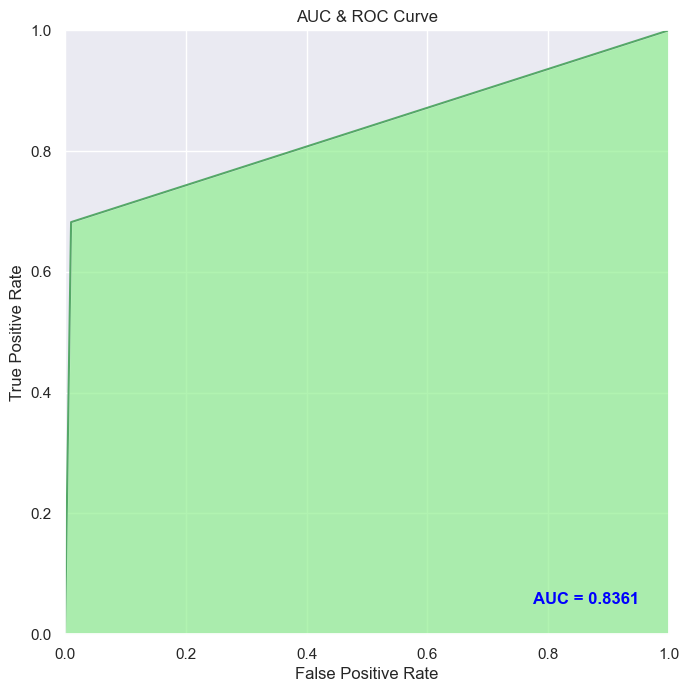

In [164]:
auc = roc_auc_score(y_val, y_val_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Random Forest

In [180]:
rf = RandomForestClassifier(n_estimators=50, max_depth=7, class_weight= {1: positive_class, 0: negative_class})

In [181]:
rf.fit(X_train2, y_train2)

RandomForestClassifier(class_weight={0: 0.82, 1: 0.18}, max_depth=7,
                       n_estimators=50)

In [182]:
y_val_pred = rf.predict(X_val)

In [183]:
precision_score(y_val, y_val_pred)

0.9968108946733322

In [184]:
recall_score(y_val, y_val_pred)

0.6505231184610193

In [138]:
rf_confusion_matrix_data = {'Actual' : y_val, 'Predicted' : y_val_pred}

In [139]:
rf_confusion_matrix_df = pd.DataFrame(rf_confusion_matrix_data, columns=['Actual','Predicted'])

In [140]:
confusion_matrix = pd.crosstab(rf_confusion_matrix_df['Actual'], rf_confusion_matrix_df['Predicted'], rownames=['Actual'], colnames=['Predicted'])

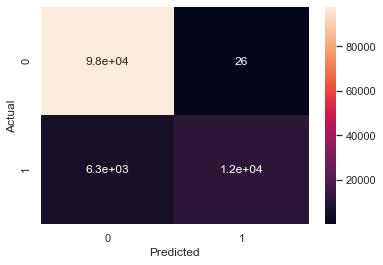

In [141]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

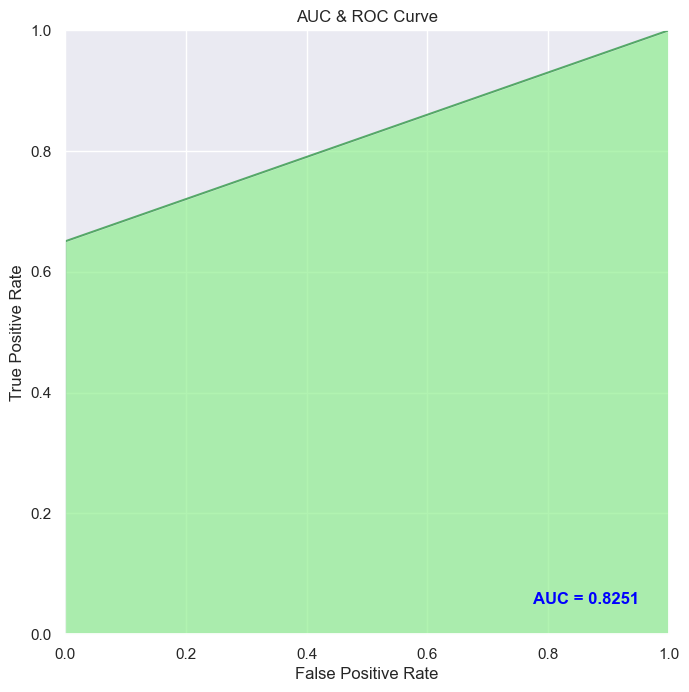

In [185]:
auc = roc_auc_score(y_val, y_val_pred)

false_positive_rate, true_positive_rate, thresolds = roc_curve(y_val, y_val_pred)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.title("AUC & ROC Curve")
plt.plot(false_positive_rate, true_positive_rate, 'g')
plt.fill_between(false_positive_rate, true_positive_rate, facecolor='lightgreen', alpha=0.7)
plt.text(0.95, 0.05, 'AUC = %0.4f' % auc, ha='right', fontsize=12, weight='bold', color='blue')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
grid = np.mgrid[0:1.02:0.02, 0:1.02:0.02].reshape(2,-1).T
visualize(grid, decisiontree.predict(grid))

In [ ]:
SSS = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

In [ ]:
#feature importance

In [ ]:
#confusion matrix 

In [114]:
scores = []

In [115]:
rf = RandomForestClassifier(n_estimators=50, max_depth=7)

for train_index, test_index in SSS.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    scores.append(precision_score(y_test, pred))

KeyError: "None of [Int64Index([647968,  73966, 586447, 577734, 170460, 139361,  44611, 158622,\n            433200,  90214,\n            ...\n             47575, 437316, 312501, 464259, 157279, 248824, 201078,  99613,\n            426411, 323281],\n           dtype='int64', length=578034)] are in the [columns]"